In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [01:08<00:00, 147MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


In [25]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [27]:
print("Root directory:")
print(os.listdir(path))

print("\nInside food-101 folder:")
print(os.listdir(os.path.join(path, "food-101")))

Root directory:
['food-101', 'food-101.zip']

Inside food-101 folder:
['food-101', '__MACOSX']


In [29]:
DATASET_PATH = os.path.join(path, "food-101", "food-101")
IMAGE_PATH = os.path.join(DATASET_PATH, "images")

print("Dataset contents:", os.listdir(DATASET_PATH))
print("Number of class folders:", len(os.listdir(IMAGE_PATH)))

Dataset contents: ['license_agreement.txt', 'images', 'README.txt', 'meta', '.DS_Store']
Number of class folders: 102


In [30]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [31]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(101, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [33]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# choose first 20 classes only
selected_classes = list(train_gen.class_indices.keys())[:20]

subset_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_sub = subset_gen.flow_from_directory(
    IMAGE_PATH,
    classes=selected_classes,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_sub = subset_gen.flow_from_directory(
    IMAGE_PATH,
    classes=selected_classes,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 16000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


In [35]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    steps_per_epoch=50,        # instead of ~2500
    validation_steps=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.0098 - loss: 4.6803 - val_accuracy: 0.0078 - val_loss: 4.6209


In [36]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    steps_per_epoch=50,      # VERY IMPORTANT: limits time
    validation_steps=20
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.0087 - loss: 4.6859 - val_accuracy: 0.0078 - val_loss: 4.6348


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


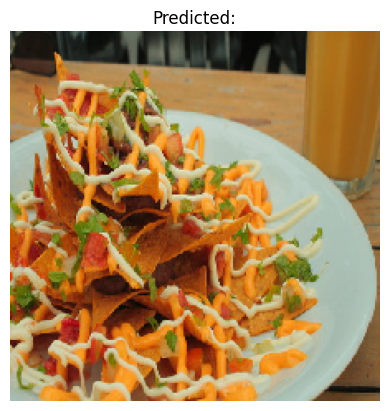

In [49]:
from tensorflow.keras.preprocessing import image

# pick one image from dataset
sample_class = list(train_gen.class_indices.keys())[66]
sample_dir = os.path.join(IMAGE_PATH, sample_class)
sample_img = os.listdir(sample_dir)[5]

img_path = os.path.join(sample_dir, sample_img)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = list(train_gen.class_indices.keys())[np.argmax(pred)]

plt.imshow(img)
plt.title(f"Predicted:")
plt.axis("off")
plt.show()